In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, h5py, gc, numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
import concurrent.futures as cf
from pathlib import Path
from torch.utils.data import DataLoader

REPO_ROOT = "../"
proj = Path(REPO_ROOT).resolve()

# allow: import ADCNN.*
sys.path.insert(0, str(proj))

# allow: import utils.*  (where utils == ADCNN/utils)
sys.path.insert(0, str(proj / "ADCNN"))

import exp_utils.postprocess as postprocess
from ADCNN.data.h5tiles import H5TiledDataset
from ADCNN.predict import load_model, predict_tiles_to_full
import ADCNN.evals.basic_evals as evals
import ADCNN.evals.threshold_scan as threshold_scan

test_h5 = "../DATA/test.h5"
test_csv = "../DATA/test.csv"
MODEL_CKPT = "../checkpoints/Best/ckpt_best.pt"
SAVE_PATH = "../checkpoints/Experiments/"

In [2]:
def calculate_model_metrics (catalog, predictions, ground_truth, thr_points=100, stack_fp=None):
    catalog = catalog.copy()
    threshold_df = threshold_scan.scan_thresholds(catalog=catalog, predictions=predictions, ground_truth=ground_truth, stack_fp=stack_fp, n_points=thr_points)
    threshold_scan.plot_fscore(threshold_df["thr"], pix_f1=threshold_df.get("pix_f1"), pix_f2=threshold_df.get("pix_f2"),
                               obj_f1=threshold_df.get("obj_f1"), obj_f2=threshold_df.get("obj_f2"), title="Pixelwise vs Objectwise F-scores")
    threshold_scan.plot_roc(threshold_scan.compute_roc(threshold_df["pix_tp"], threshold_df["pix_fp"], threshold_df["pix_tn"], threshold_df["pix_fn"]))
    threshold_scan.plot_froc(threshold_scan.compute_froc(thr=threshold_df["thr"], obj_tp=threshold_df["obj_tp"], obj_fp=threshold_df["obj_fp"], obj_fn=threshold_df["obj_fn"], n_images=50),
                             title="FROC (objectwise)")
    best_threshold = threshold_df["thr"][threshold_df["obj_f2"].argmax()]
    _,_,catalog = evals.confusion_matrix(catalog=catalog, ground_truth= ground_truth,predictions=predictions, stack_fp=stack_fp, threshold=best_threshold, verbose=True)
    _ = evals.plot_detect_hist(catalog, "PSF_mag", bins=12, title="NN detections vs PSF_mag threshold=" + str(round(best_threshold, 3)))
    _ = evals.plot_detect_hist(catalog, "trail_length", bins=12, title="Detections vs trail length threshold="+ str(round(best_threshold, 3)))
    _ = evals.plot_detect_hist(catalog, "SNR", bins=10, title="Detections vs SNR threshold="+ str(round(best_threshold, 3)), xlim=[0, 10], density=True)
    plt.show()
    return catalog

In [3]:
ds_te = H5TiledDataset(test_h5,  tile=128, k_sigma=5.0)

test_loader = DataLoader(
    ds_te,
    batch_size=128,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False,
    prefetch_factor=None,
)

test_catalog = pd.read_csv(test_csv)
with h5py.File(test_h5, "r") as _f:
    gt_test = _f["masks"][:].astype(np.uint8)
    stack_fp = _f["real_labels"][:].astype(np.uint16)
print("Test tiles:", len(ds_te))

Test tiles: 51200


In [4]:
model_baseline = load_model(SAVE_PATH+"Last/Baseline.pt")
p_baseline = predict_tiles_to_full(test_h5, test_loader, model_baseline, tile=128)
model_baseline.to('cpu')
gc.collect()
del model_baseline
torch.cuda.empty_cache()
p_4 = postprocess.two_threshold_prediction(p_baseline, t_low=0.01)
cat_4 = calculate_model_metrics(test_catalog, p_4, gt_test, stack_fp=stack_fp)

Loaded model from: ../checkpoints/Experiments/Last/Baseline.pt


KeyboardInterrupt: 

In [42]:
p_4 = postprocess.two_threshold_prediction(p_baseline, t_low=0.05, pixel_gap=1)

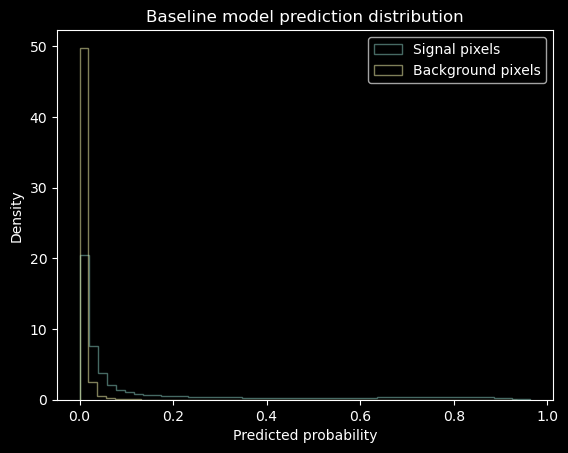

In [43]:
plt.hist(p_baseline[gt_test>0.5].flatten(), bins=50, alpha=0.5, label='Signal pixels', histtype='step', density=True)
plt.hist(p_baseline[gt_test==0].flatten(), bins=50, alpha=0.5, label='Background pixels', histtype='step', density=True)
plt.xlabel('Predicted probability')
plt.ylabel('Density')
plt.legend()
plt.title('Baseline model prediction distribution')
plt.show()



Object at x=3469, y=1276, SNR=8.37


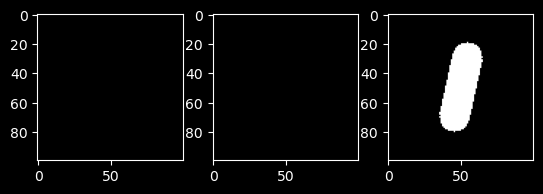

Object at x=1679, y=1100, SNR=2.55


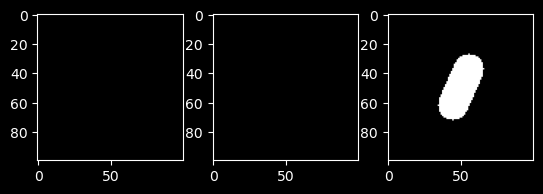

Object at x=272, y=1124, SNR=9.07


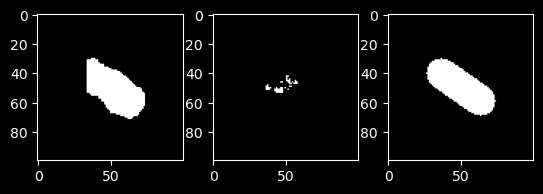

Object at x=2342, y=563, SNR=3.91


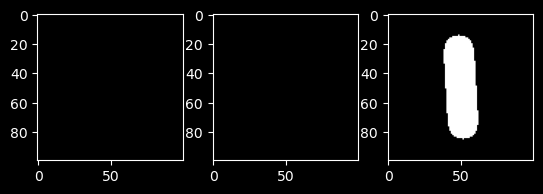

Object at x=2636, y=353, SNR=6.75


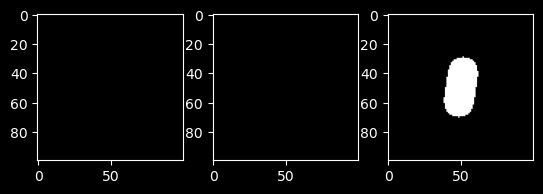

Object at x=1586, y=475, SNR=2.44


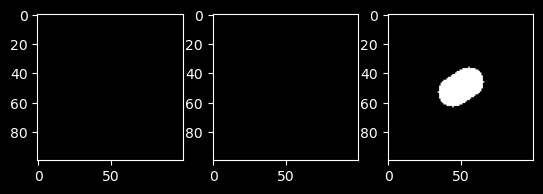

Object at x=559, y=3308, SNR=6.69


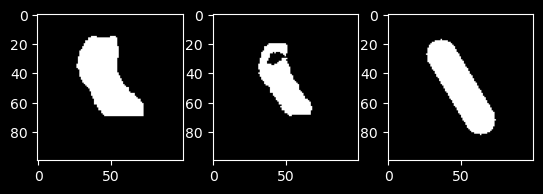

Object at x=841, y=3791, SNR=4.30


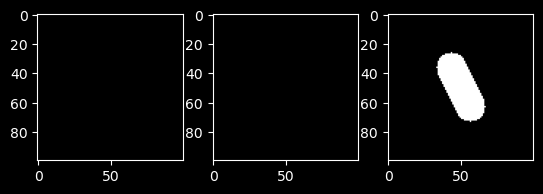

Object at x=3029, y=343, SNR=9.68


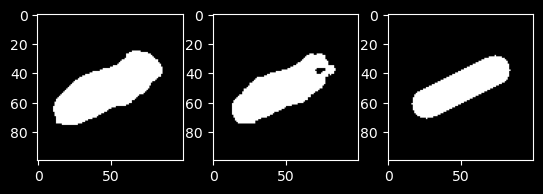

Object at x=764, y=2177, SNR=4.79


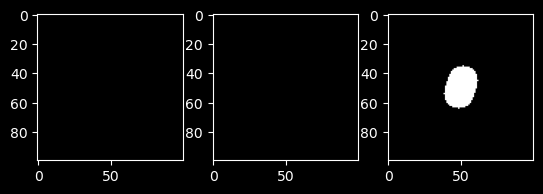

Object at x=3038, y=2661, SNR=9.73


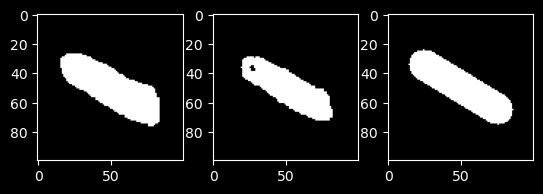

Object at x=2726, y=2672, SNR=4.08


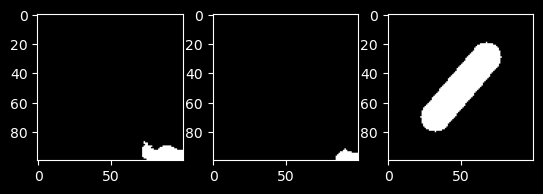

Object at x=1260, y=924, SNR=6.62


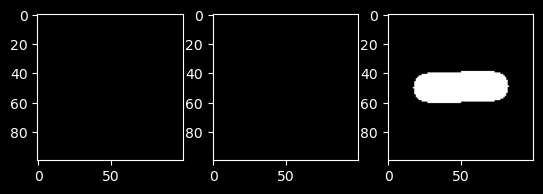

Object at x=3026, y=1326, SNR=4.47


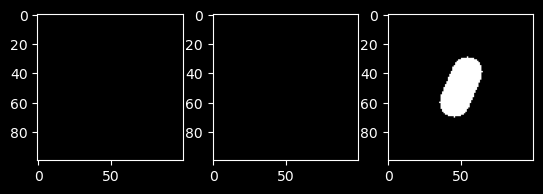

Object at x=3938, y=3132, SNR=3.20


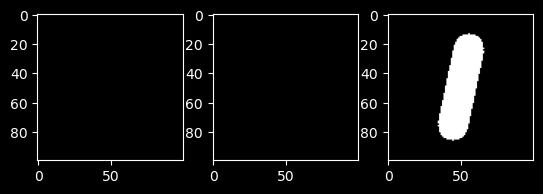

Object at x=3104, y=3057, SNR=2.35


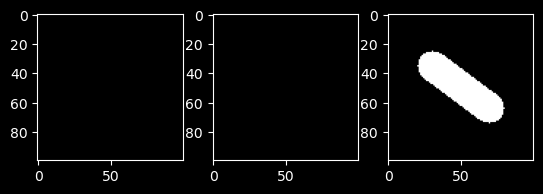

Object at x=1356, y=3821, SNR=9.94


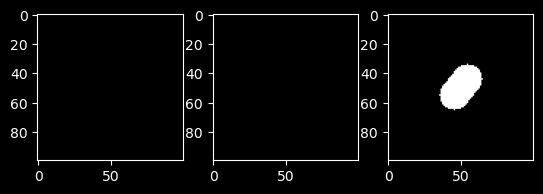

Object at x=1310, y=3368, SNR=9.73


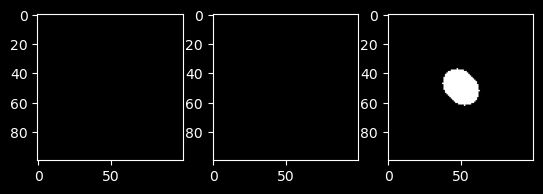

Object at x=1867, y=622, SNR=8.63


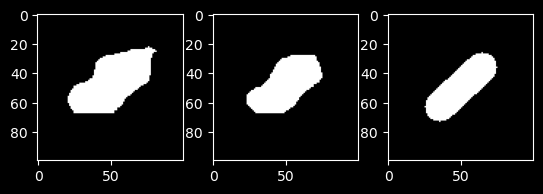

Object at x=1429, y=1030, SNR=5.41


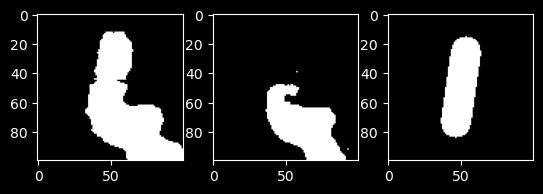

In [68]:
import matplotlib.pyplot as plt
size = 50
threshold = 0.182
for x,y,snr in cat_4[cat_4['image_id']==10][['x','y','SNR']].values:
    x = int(x)
    y = int(y)
    print (f'Object at x={x}, y={y}, SNR={snr:.2f}')
    cutout_p = p_4[10, y-size:y+size, x-size:x+size] > threshold
    cutout_p_baseline = p_baseline[10][y-size:y+size, x-size:x+size] > threshold
    cutout_gt = gt_test[10][y-size:y+size, x-size:x+size] > 0.5
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(cutout_p, cmap='gray', vmin=0, vmax=1)
    ax[1].imshow(cutout_p_baseline, cmap='gray', vmin=0, vmax=1)
    ax[2].imshow(cutout_gt, cmap='gray')
    plt.show()

In [67]:
p_4[10, 3469, 1276]

np.float32(0.006426699)

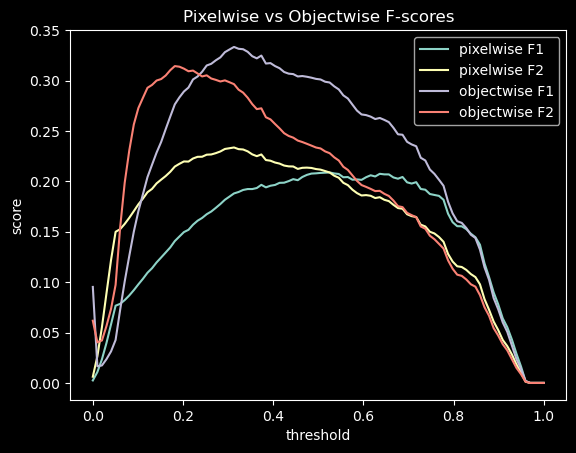

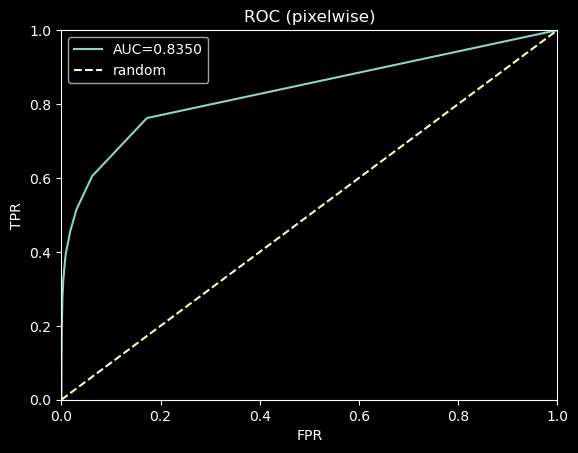

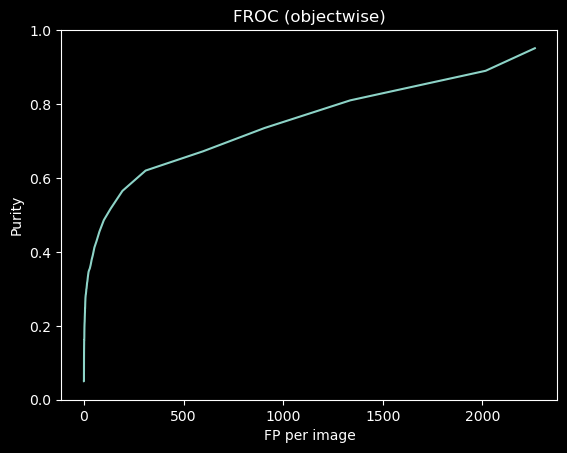

Pixel-wise Confusion Matrix
F1 Score: 0.1408, F2 Score: 0.2147
                 Predicted Negative  Predicted Positive
Actual Negative           810007690             3384916
Actual Positive              674714              332680

Object-wise Confusion Matrix
F1 Score: 0.2767, F2 Score: 0.3145
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>                1155
Actual Positive                 654                 346



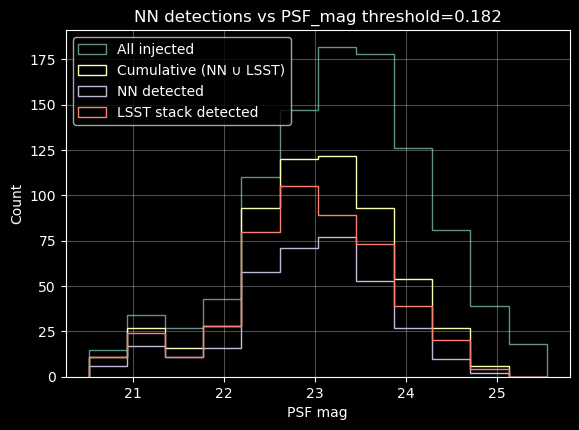

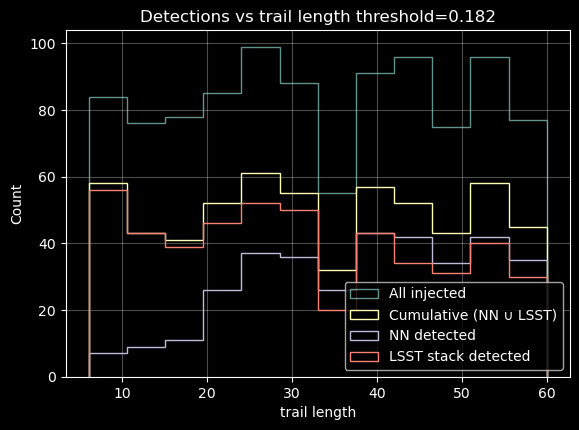

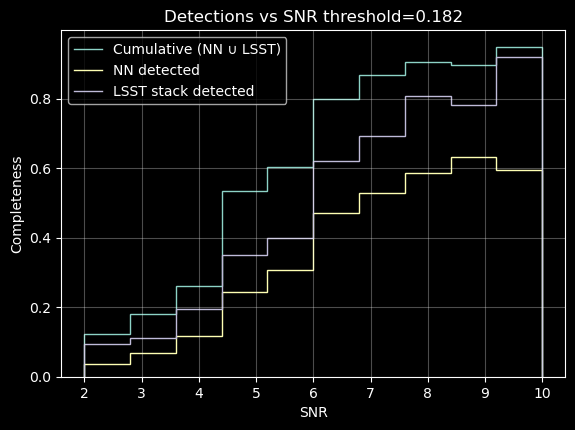

In [49]:
cat_4 = calculate_model_metrics(test_catalog, p_4, gt_test, stack_fp=stack_fp)

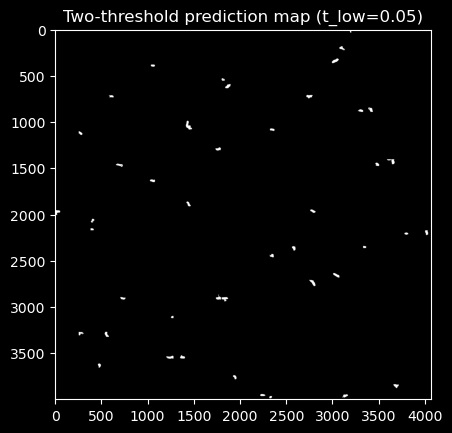

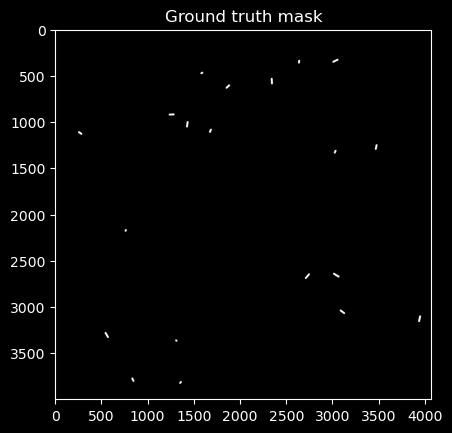

In [50]:
plt.imshow(p_4[10]>0.182, cmap='gray', vmin=0, vmax=1)
plt.title('Two-threshold prediction map (t_low=0.05)')
plt.show()
plt.imshow(gt_test[10], cmap='gray', vmin=0, vmax=1)
plt.title('Ground truth mask')
plt.show()

In [52]:
cat_4.columns

Index(['ra', 'dec', 'source_type', 'trail_length', 'mag', 'beta', 'visit',
       'detector', 'integrated_mag', 'PSF_mag', 'SNR', 'physical_filter', 'x',
       'y', 'stack_detection', 'stack_mag', 'stack_mag_err', 'stack_snr',
       'image_id', 'nn_detected'],
      dtype='object')